# Make figure 1, 3, S2, S3, S4
1 Location map\
2 Detection algorithm\
S2 Halloween Crack RGTs\
S3 Movement of GNSS and comparison RGTs\
S4 "opening" v "wall-to-wall" widths 

### load necessary libraries

In [1]:
import pickle
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import math
import shapefile
from rasterio.plot import show
from rasterio.merge import merge
from matplotlib.patches import Rectangle
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from rasterio.warp import calculate_default_transform, reproject, Resampling
from scipy import stats
from pyproj import Transformer
from pyproj import Geod
from netCDF4 import Dataset 
from matplotlib_scalebar.scalebar import ScaleBar


In [2]:
figure_folder = '/home/ram21/notebooks/brunt-is2-rifts/figures'

atl06_path = '/data/fast1/arc/atl06/brunt.pkl'

HCobs_path = '/home/ram21/notebooks/brunt-is2-rifts/brunt_himedlow_mdt_halloween_merged.pickle'
HCobs_unmerged_path = '/home/ram21/notebooks/brunt-is2-rifts/brunt_himedlow_mdt_halloween.pickle'

satellite_path = '/home/ram21/notebooks/brunt-is2-rifts/halloween/'


### Load ATL06 and rift observations

In [3]:
# load atl06
with open(atl06_path, 'rb') as handle:
    atl06_data = pickle.load(handle)
atl06_data = pd.DataFrame(atl06_data)

with open(HCobs_path, 'rb') as handle:
    halloween_obs_merged = pickle.load(handle)
    
with open(HCobs_unmerged_path, 'rb') as handle:
    halloween_obs_unmerged = pickle.load(handle)    


### Subset ITS_LIVE velocity

In [4]:
import xarray as xr 
import rioxarray as rio 

nc_file = xr.open_dataset('/data/fast0/datasets/ANT_G0120_0000.nc')
display(nc_file)

vx = nc_file['vx']
vy = nc_file['vy']

x = nc_file['x']
y = nc_file['y']
xmesh,ymesh = np.meshgrid(x,y)

'''
vv = np.sqrt((vx**2)+(vy**2))
vv = vv.rio.set_spatial_dims('x', 'y')
vv.rio.crs

vv.rio.set_crs("epsg:3031")

geometries = [
    {
        'type': 'Polygon',
        'coordinates': [[
            [-780000, 1350000],
            [-780000, 1500000],
            [-620000, 1500000],
            [-620000, 1350000],
            [-780000, 1350000]
        ]]
    }
]



vvclip = vv.rio.clip(geometries)

vvclip.rio.to_raster(r"vv.tiff")

#or save full raster
#vv.rio.to_raster(r"vv.tiff")
'''


<xarray.Dataset>
Dimensions:              (x: 45792, y: 36784)
Coordinates:
  * x                    (x) float64 -2.678e+06 -2.678e+06 ... 2.817e+06
  * y                    (y) float64 2.26e+06 2.26e+06 ... -2.154e+06 -2.154e+06
Data variables: (12/14)
    vx                   (y, x) float32 ...
    vy                   (y, x) float32 ...
    v                    (y, x) float32 ...
    vx_err               (y, x) float32 ...
    vy_err               (y, x) float32 ...
    v_err                (y, x) float32 ...
    ...                   ...
    count                (y, x) float32 ...
    chip_size_max        (y, x) float32 ...
    ocean                (y, x) float32 ...
    rock                 (y, x) float32 ...
    ice                  (y, x) float32 ...
    Polar_Stereographic  |S1 ...
Attributes:
    GDAL_AREA_OR_POINT:       Area
    date_created:             05-May-2019 19:16:06
    title:                    autoRIFT surface velocities
    author:                   Alex S. Gardner, JPL/NASA
    institution:              NASA Jet Propulsion Laboratory (JPL), Californi...
    scene_pair_type:          optical
    motion_detection_method:  feature
    motion_coordinates:       map

'\nvv = np.sqrt((vx**2)+(vy**2))\nvv = vv.rio.set_spatial_dims(\'x\', \'y\')\nvv.rio.crs\n\nvv.rio.set_crs("epsg:3031")\n\ngeometries = [\n    {\n        \'type\': \'Polygon\',\n        \'coordinates\': [[\n            [-780000, 1350000],\n            [-780000, 1500000],\n            [-620000, 1500000],\n            [-620000, 1350000],\n            [-780000, 1350000]\n        ]]\n    }\n]\n\n\n\nvvclip = vv.rio.clip(geometries)\n\nvvclip.rio.to_raster(r"vv.tiff")\n\n#or save full raster\n#vv.rio.to_raster(r"vv.tiff")\n'

### Figure 1
Location map:
a) Overview of Brunt ice shelf, rgts, GPS, with inset map of Antarctica  
b) velocity  
c) Zoom on western Halloween crack/North rift with GPS (highlight 215 1LR, 1160 3LR, 7862 LR)  
d) Zoom on eastern Halloween crack/North rift with GPS (highlight 283 1LR, 725 3LR, 1099 2LR)  

In [5]:
# Load Landsat and mosaic

landsat_out_B2 = '/home/ram21/notebooks/brunt-is2-rifts/halloween/landsat/LC08_L1GT_184113_184114_20200220_B2_merge.tif'
landsat_out_B3 = '/home/ram21/notebooks/brunt-is2-rifts/halloween/landsat/LC08_L1GT_184113_184114_20200220_B3_merge.tif'
landsat_out_B4 = '/home/ram21/notebooks/brunt-is2-rifts/halloween/landsat/LC08_L1GT_184113_184114_20200220_B4_merge.tif'

landsat_names_B2 = ['/home/ram21/notebooks/brunt-is2-rifts/halloween/landsat/LC08_L1GT_184113_20200220_20201016_02_T2/LC08_L1GT_184113_20200220_20201016_02_T2_B2.TIF',
                    '/home/ram21/notebooks/brunt-is2-rifts/halloween/landsat/LC08_L1GT_184114_20200220_20201016_02_T2/LC08_L1GT_184114_20200220_20201016_02_T2_B2.TIF']
 
landsat_names_B3 = ['/home/ram21/notebooks/brunt-is2-rifts/halloween/landsat/LC08_L1GT_184113_20200220_20201016_02_T2/LC08_L1GT_184113_20200220_20201016_02_T2_B3.TIF',
                    '/home/ram21/notebooks/brunt-is2-rifts/halloween/landsat/LC08_L1GT_184114_20200220_20201016_02_T2/LC08_L1GT_184114_20200220_20201016_02_T2_B3.TIF']
  
landsat_names_B4 = ['/home/ram21/notebooks/brunt-is2-rifts/halloween/landsat/LC08_L1GT_184113_20200220_20201016_02_T2/LC08_L1GT_184113_20200220_20201016_02_T2_B4.TIF',
                    '/home/ram21/notebooks/brunt-is2-rifts/halloween/landsat/LC08_L1GT_184114_20200220_20201016_02_T2/LC08_L1GT_184114_20200220_20201016_02_T2_B4.TIF']

B2_files_to_mosaic = []
B3_files_to_mosaic = []
B4_files_to_mosaic = []

for fp2 in landsat_names_B2:
    src2 = rasterio.open(fp2)
    B2_files_to_mosaic.append(src2)
    
mosaic_B2, out_trans_B2 = merge(B2_files_to_mosaic)

for fp3 in landsat_names_B3:
    src3 = rasterio.open(fp3)
    B3_files_to_mosaic.append(src3)
    
mosaic_B3, out_trans_B3 = merge(B3_files_to_mosaic)

for fp4 in landsat_names_B4:
    src4 = rasterio.open(fp4)
    B4_files_to_mosaic.append(src4)

mosaic_B4, out_trans_B4 = merge(B4_files_to_mosaic)

out_meta = src2.meta.copy()
out_meta.update({'driver': 'GTiff',
                 'dtype': 'uint16',
                 'nodata': 0.0,
                 'width': mosaic_B2.shape[2],
                 'height': mosaic_B2.shape[1],
                 'count': 1,
                 'transform': out_trans_B2
                })
    
with rasterio.open(landsat_out_B2, "w", **out_meta) as dest:
    dest.write(mosaic_B2)
    
with rasterio.open(landsat_out_B3, "w", **out_meta) as dest:    
    dest.write(mosaic_B3)
    
with rasterio.open(landsat_out_B4, "w", **out_meta) as dest:   
    dest.write(mosaic_B4)    

img1_2 = rasterio.open(landsat_out_B2)
img1_3 = rasterio.open(landsat_out_B3)
img1_4 = rasterio.open(landsat_out_B4)

#crop to 99th percentile (stops dull images)
image1_2 = img1_2.read(1)
image1_2[image1_2 > np.percentile(image1_2,99)] = np.percentile(image1_2,99)
image1_3 = img1_3.read(1)
image1_3[image1_3 > np.percentile(image1_3,99)] = np.percentile(image1_3,99)
image1_4 = img1_4.read(1)
image1_4[image1_4 > np.percentile(image1_4,99)] = np.percentile(image1_4,99)

image1 = np.array([image1_4, image1_3, image1_2]).transpose(1,2,0)
norm1 = (image1 * (255 / np.max(image1))).astype(np.uint8)


In [6]:
print(out_trans_B2)

| 30.00, 0.00,-819915.00|
| 0.00,-30.00, 1635615.00|
| 0.00, 0.00, 1.00|


In [7]:
# Load the ICESat-2 rgts
transformer = Transformer.from_crs("EPSG:4326","EPSG:3031")

shpfile1L = "/home/ram21/notebooks/brunt-is2-rifts/halloween/shapefiles_for_plotting/Antarctica_repeat1_GT1L_Antarctica_1_laser1.shp"
shpfile1R = "/home/ram21/notebooks/brunt-is2-rifts/halloween/shapefiles_for_plotting/Antarctica_repeat1_GT1R_Antarctica_1_laser2.shp"
shpfile7  = "/home/ram21/notebooks/brunt-is2-rifts/halloween/shapefiles_for_plotting/Antarctica_repeat1_GT7_Antarctica_1_laser7.shp"
shapefile1L = gpd.read_file(shpfile1L)
shapefile1R = gpd.read_file(shpfile1R)
shapefile7  = gpd.read_file(shpfile7)

shapefile1L_ar = {
    "name": [],
    "easting": [],
    "northing": []
    }

shapefile1R_ar = {
    "name": [],
    "easting": [],
    "northing": []
    }

shapefile7_ar = {
    "name": [],
    "easting": [],
    "northing": []
    }

for b1L in range(0,len(shapefile1L.Name)):
    geometry = np.array(shapefile1L.geometry[b1L])
    if (len(geometry) > 2):
        shapefile1L_ar["name"].append(int(shapefile1L.Name[b1L]))
        lon = geometry[:,0]
        lat = geometry[:,1]
        [easting,northing] = transformer.transform(lat,lon)
        shapefile1L_ar["easting"].append(easting)
        shapefile1L_ar["northing"].append(northing)
        
for b1R in range(0,len(shapefile1R.Name)):
    geometry = np.array(shapefile1R.geometry[b1R])
    if (len(geometry) > 2):
        shapefile1R_ar["name"].append(int(shapefile1R.Name[b1R]))
        lon = geometry[:,0]
        lat = geometry[:,1]
        [easting,northing] = transformer.transform(lat,lon)
        shapefile1R_ar["easting"].append(easting)
        shapefile1R_ar["northing"].append(northing)        

for b7 in range(0,len(shapefile7.Name)):
    geometry = np.array(shapefile7.geometry[b7])
    if (len(geometry) > 2):
        shapefile7_ar["name"].append(int(shapefile7.Name[b7]))
        lon = geometry[:,0]
        lat = geometry[:,1]
        [easting,northing] = transformer.transform(lat,lon)
        shapefile7_ar["easting"].append(easting)
        shapefile7_ar["northing"].append(northing)

shapefile1L_ar = pd.DataFrame(shapefile1L_ar)
shapefile1R_ar = pd.DataFrame(shapefile1R_ar)
shapefile7_ar  = pd.DataFrame(shapefile7_ar)


/tmp/ipykernel_3778450/3118829475.py:30: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'MultiLineString'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  geometry = np.array(shapefile1L.geometry[b1L])
/tmp/ipykernel_3778450/3118829475.py:30: FutureWarning: The input object of type 'LineString' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'LineString', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  geometry = np.array(shapefile1L.geometry[b1L])
/tmp/ipykernel_3778450/3118829475.py

In [8]:
shpfile2L = "/home/ram21/notebooks/brunt-is2-rifts/halloween/shapefiles_for_plotting/Antarctica_repeat1_GT2L_Antarctica_1_laser3.shp"
shpfile2R = "/home/ram21/notebooks/brunt-is2-rifts/halloween/shapefiles_for_plotting/Antarctica_repeat1_GT2R_Antarctica_1_laser4.shp"
shpfile3L = "/home/ram21/notebooks/brunt-is2-rifts/halloween/shapefiles_for_plotting/Antarctica_repeat1_GT3L_Antarctica_1_laser5.shp"
shpfile3R = "/home/ram21/notebooks/brunt-is2-rifts/halloween/shapefiles_for_plotting/Antarctica_repeat1_GT3R_Antarctica_1_laser6.shp"

shapefile2L = gpd.read_file(shpfile2L)
shapefile2R = gpd.read_file(shpfile2R)
shapefile3L = gpd.read_file(shpfile3L)
shapefile3R = gpd.read_file(shpfile3R)

shapefile2L_ar = {
    "name": [],
    "easting": [],
    "northing": []
    }

shapefile2R_ar = {
    "name": [],
    "easting": [],
    "northing": []
    }

shapefile3L_ar = {
    "name": [],
    "easting": [],
    "northing": []
    }

shapefile3R_ar = {
    "name": [],
    "easting": [],
    "northing": []
    }
        
for b2L in range(0,len(shapefile2L.Name)):
    geometry = np.array(shapefile2L.geometry[b2L])
    if (len(geometry) > 2):
        shapefile2L_ar["name"].append(int(shapefile2L.Name[b2L]))
        lon = geometry[:,0]
        lat = geometry[:,1]
        [easting,northing] = transformer.transform(lat,lon)
        shapefile2L_ar["easting"].append(easting)
        shapefile2L_ar["northing"].append(northing)
        
for b2R in range(0,len(shapefile2R.Name)):
    geometry = np.array(shapefile2R.geometry[b2R])
    if (len(geometry) > 2):
        shapefile2R_ar["name"].append(int(shapefile2R.Name[b2R]))
        lon = geometry[:,0]
        lat = geometry[:,1]
        [easting,northing] = transformer.transform(lat,lon)
        shapefile2R_ar["easting"].append(easting)
        shapefile2R_ar["northing"].append(northing)
        
for b3L in range(0,len(shapefile3L.Name)):
    geometry = np.array(shapefile3L.geometry[b3L])
    if ((b3L != 43)&(b3L != 54)&(b3L != 66)&(b3L != 78)&(b3L != 88)&(b3L != 122)&(b3L != 133)&(b3L != 145)&\
        (b3L != 157)&(b3L != 169)&(b3L != 192)&(b3L != 203)&(b3L != 214)&(b3L != 225)&(b3L != 237)&(b3L != 249)&(b3L != 250)):
        if (len(geometry) > 2):
            shapefile3L_ar["name"].append(int(shapefile3L.Name[b3L]))
            lon = geometry[:,0]
            lat = geometry[:,1]
            [easting,northing] = transformer.transform(lat,lon)
            shapefile3L_ar["easting"].append(easting)
            shapefile3L_ar["northing"].append(northing)
            
for b3R in range(0,len(shapefile3R.Name)):
    geometry = np.array(shapefile3R.geometry[b3R])
    if ((b3R != 43)&(b3R != 54)&(b3R != 66)&(b3R != 78)&(b3R != 88)&(b3R != 122)&(b3R != 133)&(b3R != 145)&\
        (b3R != 157)&(b3R != 169)&(b3R != 192)&(b3R != 203)&(b3R != 214)&(b3R != 226)&(b3R != 238)&(b3R != 250)):
        if (len(geometry) > 2):
            shapefile3R_ar["name"].append(int(shapefile3R.Name[b3R]))
            lon = geometry[:,0]
            lat = geometry[:,1]
            [easting,northing] = transformer.transform(lat,lon)
            shapefile3R_ar["easting"].append(easting)
            shapefile3R_ar["northing"].append(northing)
                
shapefile2L_ar = pd.DataFrame(shapefile2L_ar)
shapefile2R_ar = pd.DataFrame(shapefile2R_ar)
shapefile3L_ar = pd.DataFrame(shapefile3L_ar)
shapefile3R_ar = pd.DataFrame(shapefile3R_ar)


/tmp/ipykernel_3778450/1566473776.py:56: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'MultiLineString'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  geometry = np.array(shapefile3L.geometry[b3L])
/tmp/ipykernel_3778450/1566473776.py:56: FutureWarning: The input object of type 'LineString' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'LineString', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  geometry = np.array(shapefile3L.geometry[b3L])
/tmp/ipykernel_3778450/1566473776.py

In [9]:
# Load Antarctic shapefiles

shpfileADD = "/home/ram21/notebooks/brunt-is2-rifts/halloween/shapefiles_for_plotting/add_coastline_medium_res_polygon_v7_6.shp"
shapefileADD = gpd.read_file(shpfileADD)

shapefileADD_Land = shapefileADD[shapefileADD.surface=="land"]
shapefileADD_shelf = shapefileADD[shapefileADD.surface=="ice shelf"]

shpfileASAIDGL = "/home/ram21/notebooks/brunt-is2-rifts/halloween/shapefiles_for_plotting/ASAID_GroundingLine_Continent.shp"
shapefileASAIDGL = gpd.read_file(shpfileASAIDGL)


In [10]:
# Load rift shapefiles

# Halloween 2020 02 20
shpfileHC = "/home/ram21/notebooks/brunt-is2-rifts/halloween/shapefiles_for_plotting/Halloween_crack.shp"
shapefileHC = gpd.read_file(shpfileHC)

# Chasm 1 2020 02 20
shpfileC1 = "/home/ram21/notebooks/brunt-is2-rifts/halloween/shapefiles_for_plotting/Chasm_1.shp"
shapefileC1 = gpd.read_file(shpfileC1)

# North 2021 02 06
shpfileNR = "/home/ram21/notebooks/brunt-is2-rifts/halloween/shapefiles_for_plotting/North_rift.shp"
shapefileNR = gpd.read_file(shpfileNR)


In [11]:
# work out a north arrow

transformer = Transformer.from_crs("EPSG:4326","EPSG:3031")
[e1,n1] = transformer.transform(-75.6,-29.5)
[e2,n2] = transformer.transform(-75.7,-29.5)


### Load GNSS
Global Navigation Satellite System monthly position/time observations from GNSS receivers hh00 and tt05 ("western pair") and ss00 and tt04 ("eastern pair") across Halloween Crack. A small number of observations are removed so receivers within each pair have the same time vectors.

In [12]:
# Load GNSS
gps = pd.read_csv('/home/ram21/notebooks/brunt-is2-rifts/GPS/bas_marsh_monthly_halloween_updated.csv')

hh00_x = np.array(gps.PSX[ gps.Site=='HH00' ])
hh00_y = np.array(gps.PSY[ gps.Site=='HH00' ])
tt05_x = np.array(gps.PSX[ gps.Site=='TT05' ])
tt05_y = np.array(gps.PSY[ gps.Site=='TT05' ])
ss00_x = np.array(gps.PSX[ gps.Site=='SS00' ])
ss00_y = np.array(gps.PSY[ gps.Site=='SS00' ])
tt04_x = np.array(gps.PSX[ gps.Site=='TT04' ])
tt04_y = np.array(gps.PSY[ gps.Site=='TT04' ])
tt01_x = np.array(gps.PSX[ gps.Site=='TT01' ])
tt01_y = np.array(gps.PSY[ gps.Site=='TT01' ])

hh00_t = np.array(gps.YYYY[gps.Site=='HH00' ]) + (np.array(gps.MM[gps.Site=='HH00' ]) / 12) - (15/365)
tt05_t = np.array(gps.YYYY[gps.Site=='TT05' ]) + (np.array(gps.MM[gps.Site=='TT05' ]) / 12) - (15/365)
ss00_t = np.array(gps.YYYY[gps.Site=='SS00' ]) + (np.array(gps.MM[gps.Site=='SS00' ]) / 12) - (15/365)
tt04_t = np.array(gps.YYYY[gps.Site=='TT04' ]) + (np.array(gps.MM[gps.Site=='TT04' ]) / 12) - (15/365)
tt01_t = np.array(gps.YYYY[gps.Site=='TT01' ]) + (np.array(gps.MM[gps.Site=='TT01' ]) / 12) - (15/365)

hh00_vx = stats.linregress(hh00_t, hh00_x).slope
hh00_vy = stats.linregress(hh00_t, hh00_y).slope
tt05_vx = stats.linregress(tt05_t, tt05_x).slope
tt05_vy = stats.linregress(tt05_t, tt05_y).slope
ss00_vx = stats.linregress(ss00_t, ss00_x).slope
ss00_vy = stats.linregress(ss00_t, ss00_y).slope
tt04_vx = stats.linregress(tt04_t, tt04_x).slope
tt04_vy = stats.linregress(tt04_t, tt04_y).slope
tt01_vx = stats.linregress(tt01_t, tt01_x).slope
tt01_vy = stats.linregress(tt01_t, tt01_y).slope

gps_x = np.concatenate((hh00_x,tt05_x,ss00_x,tt04_x,tt01_x))
gps_y = np.concatenate((hh00_y,tt05_y,ss00_y,tt04_y,tt01_y))
gps_t = np.concatenate((hh00_t,tt05_t,ss00_t,tt04_t,tt01_t))

print(hh00_vx,hh00_vy)
print(tt05_vx,tt05_vy)
print(ss00_vx,ss00_vy)
print(tt04_vx,tt04_vy)
print(tt01_vx,tt01_vy)


-928.5715191193 -36.10077978399552
-703.5790934320061 -254.58371877890787
-979.4542096686592 42.043508962520285
-782.6453898718862 -82.84650679837743
-601.9864072319818 -401.48117873965083


/tmp/ipykernel_3778450/3322598008.py:409: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


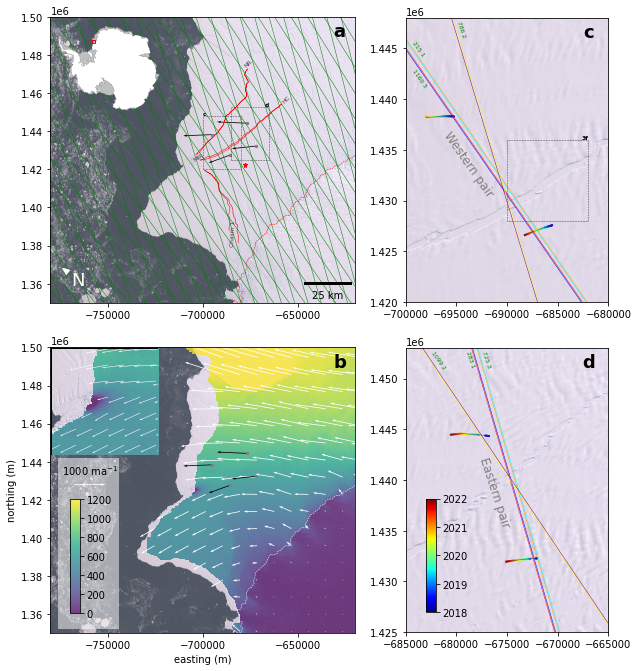

In [13]:
gr = 0.25 # gray
ftsz = 8  # fontsize

yr_min = 2018
yr_max = 2022

xmin = -780000
xmax = -620000
ymin = 1350000 
ymax = 1500000

xmininsw = -700000
xmaxinsw = -680000
ymininsw = 1420000 
ymaxinsw = 1448000

xmininse = -685000
xmaxinse = -665000
ymininse = 1425000 
ymaxinse = 1453000

xmin_mir = -712000
xmax_mir = -692000
ymin_mir = 1415000 
ymax_mir = 1435000

fig,ax=plt.subplots(2,2,figsize=(10,12),gridspec_kw={'width_ratios': [3,2], 'height_ratios': [1,1],
                                                     'wspace': 0.2,'hspace': 0.025})
        
show(norm1.transpose(2,0,1), transform=img1_2.transform, ax=ax[0][0])

# plot the GPS locations
ax[0][0].plot(hh00_x[1],hh00_y[1],'s',color='gray',markersize=2)
ax[0][0].plot(tt05_x[1],tt05_y[1],'s',color='gray',markersize=2)
ax[0][0].plot(ss00_x[0],ss00_y[0],'s',color='gray',markersize=2)
ax[0][0].plot(tt04_x[1],tt04_y[1],'s',color='gray',markersize=2)

xi=[hh00_x[1],tt05_x[1],ss00_x[0],tt04_x[1]]
yi=[hh00_y[1],tt05_y[1],ss00_y[0],tt04_y[1]]
vix=[hh00_vx,tt05_vx,ss00_vx,tt04_vx]
viy=[hh00_vy,tt05_vy,ss00_vy,tt04_vy]

Q1 = ax[0][0].quiver(xi,yi,vix,viy, scale = 10000, color='k', width=0.0025)

# plot grounding line
shapefileASAIDGL.plot(linestyle='--',color='r',ax=ax[0][0],linewidth=0.5)

# plot rifts
shapefileHC.plot(color='r',linewidth=0.5,ax=ax[0][0])
shapefileC1.plot(color='r',linewidth=0.5,ax=ax[0][0])
shapefileNR.plot(color='r',linewidth=0.5,ax=ax[0][0])

# plot Halley
halley_lat = -75.571111
halley_lon = -25.473889
transformer = Transformer.from_crs("EPSG:4326","EPSG:3031")
[halley_easting,halley_northing] = transformer.transform(halley_lat,halley_lon)
ax[0][0].plot(halley_easting,halley_northing,'*r',markersize=5)

# plot rgts (7 is the satellite reference ground tracks)
for b in range(0,len(shapefile7_ar)):
    easting = shapefile7_ar["easting"][b]
    northing = shapefile7_ar["northing"][b]
    ax[0][0].plot(easting,northing,'g',linewidth=0.5)

# plot subfig box
ax[0][0].plot([xmininse,xmininse,xmaxinse,xmaxinse,xmininse],\
           [ymininse,ymaxinse,ymaxinse,ymininse,ymininse],\
           '--',color=(gr,gr,gr),linewidth=0.5)

ax[0][0].plot([xmininsw,xmininsw,xmaxinsw,xmaxinsw,xmininsw],\
           [ymininsw,ymaxinsw,ymaxinsw,ymininsw,ymininsw],\
           '--',color=(gr,gr,gr),linewidth=0.5)

# plot north arrow
ax[0][0].annotate('N', xy=(e1,n1),xycoords='data',xytext=(e2, n2),textcoords='data',
             size=18,color='w',arrowprops=dict(arrowstyle= 'wedge',color='w'))


# plot names
ax[0][0].text(-705500, 1424360, 'MIR', rotation=30, fontsize=6, color=(gr,gr,gr))
ax[0][0].text(-658500, 1455000, 'HC', rotation=45, fontsize=6, color=(gr,gr,gr))
ax[0][0].text(-678500, 1474200, 'NR', rotation=45, fontsize=6, color=(gr,gr,gr))
ax[0][0].text(-685500, 1380000, 'Chasm 1', rotation=87.5, fontsize=6, color=(gr,gr,gr))

#scale bar
scale1 = ScaleBar(dx=1, location='lower right', box_color='none')
ax[0][0].add_artist(scale1)

# plot inset location map
axins=ax[0][0].inset_axes([0.0, 0.625, 0.375, 0.375])
shapefileADD_Land.plot(color="white",ax=axins)
shapefileADD_shelf.plot(color="0.75",ax=axins)
#shapefileADD.plot(color="white",ax=axins)
axins.plot([xmin,xmin,xmax,xmax,xmin],\
           [ymin,ymax,ymax,ymin,ymin],\
           '-',color='r',linewidth=1)
axins.axis('off')

ax[0][0].set_xlim(xmin,xmax)
ax[0][0].set_ylim(ymin,ymax)

ax[0][0].locator_params(axis='x', nbins=5)

#-------------------------------------------------

vvimg = rasterio.open("vv.tiff")

image_hidden = ax[1][0].imshow(vx,alpha=0.75,vmin=0,vmax=1200)
show(norm1.transpose(2,0,1), transform=img1_2.transform, ax=ax[1][0])
show(vvimg,ax=ax[1][0],alpha=0.75,vmin=0,vmax=1200)

ax[1][0].add_patch(Rectangle((-776000,1352000),32000,90000,
                    edgecolor = 'none',
                    facecolor = 'white',
                    alpha = 0.5))

# plot grounding line
shapefileASAIDGL.plot(linestyle='--',color='w',ax=ax[1][0],linewidth=0.5)

skip=75
Q = ax[1][0].quiver(xmesh[ ::skip, ::skip],
               ymesh[ ::skip, ::skip],
               vx[ ::skip, ::skip], 
               vy[ ::skip, ::skip], scale = 10000, color='w', width=0.0025)

ax[1][0].plot(hh00_x[1],hh00_y[1],'s',color='gray',markersize=2)
ax[1][0].plot(tt05_x[1],tt05_y[1],'s',color='gray',markersize=2)
ax[1][0].plot(ss00_x[0],ss00_y[0],'s',color='gray',markersize=2)
ax[1][0].plot(tt04_x[1],tt04_y[1],'s',color='gray',markersize=2)

Q2 = ax[1][0].quiver(xi,yi,vix,viy, scale = 10000, color='k', width=0.0025)

cbaxes = inset_axes(ax[1][0], width="3%", height="40%",loc='lower left',borderpad=2)
cbar = plt.colorbar(image_hidden,cax=cbaxes,ticks=[0,200,400,600,800,1000,1200])

ax[1][0].quiverkey(Q, 0.13,0.52, 1000, r'1000 ma$^{-1}$')

ax[1][0].set_xlim(xmin,xmax)
ax[1][0].set_ylim(ymin,ymax)

ax[1][0].locator_params(axis='x', nbins=5)

# plot inset velocity zoom
axins2=ax[1][0].inset_axes([-0.01, 0.624, 0.375, 0.375])
show(norm1.transpose(2,0,1), transform=img1_2.transform, ax=axins2)
show(vvimg,ax=axins2,alpha=0.75,vmin=0,vmax=1200)

skip=25
Qins = axins2.quiver(xmesh[ ::skip, ::skip],
               ymesh[ ::skip, ::skip],
               vx[ ::skip, ::skip], 
               vy[ ::skip, ::skip], scale = 10000/(8*0.375), color='w', width=0.005)

axins2.set_xlim(xmin_mir,xmax_mir)
axins2.set_ylim(ymin_mir,ymax_mir)

axins2.plot([xmin_mir,xmin_mir,xmax_mir,xmax_mir,xmin_mir],\
           [ymin_mir,ymax_mir,ymax_mir,ymin_mir,ymin_mir],\
           color='k',linewidth=1)

axins2.axis('off')

#-------------------------------------------------

show(norm1.transpose(2,0,1), transform=img1_2.transform, ax=ax[0][1])

#hh00
ax[0][1].plot(hh00_x,hh00_y,color=(gr,gr,gr),linewidth=0.5)
ax[0][1].scatter(hh00_x,hh00_y,s=1,c=hh00_t,cmap='jet',vmin=yr_min,vmax=yr_max)

#tt05
ax[0][1].plot(tt05_x,tt05_y,color=(gr,gr,gr),linewidth=0.5)
ax[0][1].scatter(tt05_x,tt05_y,s=1,c=tt05_t,cmap='jet',vmin=yr_min,vmax=yr_max)

#215
#1L
easting = shapefile1L_ar["easting"][34]
northing = shapefile1L_ar["northing"][34]
ax[0][1].plot(easting,northing,'orange',linewidth=0.5)
#1R
easting = shapefile1R_ar["easting"][34]
northing = shapefile1R_ar["northing"][34]
ax[0][1].plot(easting,northing,'cyan',linewidth=0.5)
#2L
easting = shapefile2L_ar["easting"][34]
northing = shapefile2L_ar["northing"][34]
#ax[0][1].plot(easting,northing,'g',linewidth=0.5)
#2R
easting = shapefile2R_ar["easting"][34]
northing = shapefile2R_ar["northing"][34]
#ax[0][1].plot(easting,northing,'g',linewidth=0.5)
#3L
easting = shapefile3L_ar["easting"][32]
northing = shapefile3L_ar["northing"][32]
#ax[0][1].plot(easting,northing,'g',linewidth=0.5)
#3R
easting = shapefile3R_ar["easting"][32]
northing = shapefile3R_ar["northing"][32]
#ax[0][1].plot(easting,northing,'g',linewidth=0.5)

#annotate
ax[0][1].text(-699400, 1444000, '215 1  ', rotation=-55, fontsize=6, color='g')

#1160
#1L
easting = shapefile1L_ar["easting"][190]
northing = shapefile1L_ar["northing"][190]
#ax[0][1].plot(easting,northing,'g',linewidth=0.5)
#1R
easting = shapefile1R_ar["easting"][190]
northing = shapefile1R_ar["northing"][190]
#ax[0][1].plot(easting,northing,'g',linewidth=0.5)
#2L
easting = shapefile2L_ar["easting"][191]
northing = shapefile2L_ar["northing"][191]
#ax[0][1].plot(easting,northing,'g',linewidth=0.5)
#2R
easting = shapefile2R_ar["easting"][192]
northing = shapefile2R_ar["northing"][192]
#ax[0][1].plot(easting,northing,'g',linewidth=0.5)
#3L
easting = shapefile3L_ar["easting"][176]
northing = shapefile3L_ar["northing"][176]
ax[0][1].plot(easting,northing,'r',linewidth=0.5)
#3R
easting = shapefile3R_ar["easting"][176]
northing = shapefile3R_ar["northing"][176]
ax[0][1].plot(easting,northing,'b',linewidth=0.5)

#annotate
ax[0][1].text(-699400, 1441250, '1160 3', rotation=-55, fontsize=6, color='g')

#786
#1L
easting = shapefile1L_ar["easting"][129]
northing = shapefile1L_ar["northing"][129]
#ax[0][1].plot(easting,northing,'g',linewidth=0.5)
#1R
easting = shapefile1R_ar["easting"][129]
northing = shapefile1R_ar["northing"][129]
#ax[0][1].plot(easting,northing,'g',linewidth=0.5)
#2L
easting = shapefile2L_ar["easting"][129]
northing = shapefile2L_ar["northing"][129]
ax[0][1].plot(easting,northing,'purple',linewidth=0.5)
#2R
easting = shapefile2R_ar["easting"][130]
northing = shapefile2R_ar["northing"][130]
ax[0][1].plot(easting,northing,'yellow',linewidth=0.5)
#3L
easting = shapefile3L_ar["easting"][119]
northing = shapefile3L_ar["northing"][119]
#ax[0][1].plot(easting,northing,'g',linewidth=0.5)
#3R
easting = shapefile3R_ar["easting"][119]
northing = shapefile3R_ar["northing"][119]
#ax[0][1].plot(easting,northing,'g',linewidth=0.5)

#annotate
ax[0][1].text(-695000, 1445800, '786 2  ', rotation=-72, fontsize=6, color='g')

#fig 2 extent
#-690000 -682000 1428000 1436000
ax[0][1].plot([-690000,-690000,-682000,-682000,-690000],\
           [1428000,1436000,1436000,1428000,1428000],\
           '--',color=(gr,gr,gr),linewidth=0.5)

ax[0][1].locator_params(axis='x', nbins=5)

ax[0][1].set_xlim(xmininsw,xmaxinsw)
ax[0][1].set_ylim(ymininsw,ymaxinsw)

#-------------------------------------------------

show(norm1.transpose(2,0,1), transform=img1_2.transform, ax=ax[1][1])

#ss00
ax[1][1].plot(ss00_x,ss00_y,color=(gr,gr,gr),linewidth=0.5)
ax[1][1].scatter(ss00_x,ss00_y,s=1,c=ss00_t,cmap='jet',vmin=yr_min,vmax=yr_max)

#tt04
ax[1][1].plot(tt04_x,tt04_y,color=(gr,gr,gr),linewidth=0.5)
pl_gps=ax[1][1].scatter(tt04_x,tt04_y,s=1,c=tt04_t,cmap='jet',vmin=yr_min,vmax=yr_max)

cbaxes = inset_axes(ax[1][1], width="5%", height="40%",loc='lower left',borderpad=2)
cbar = plt.colorbar(pl_gps,cax=cbaxes)

#283
#1L
easting = shapefile1L_ar["easting"][45]
northing = shapefile1L_ar["northing"][45]
ax[1][1].plot(easting,northing,'red',linewidth=0.5)
#1R
easting = shapefile1R_ar["easting"][45]
northing = shapefile1R_ar["northing"][45]
ax[1][1].plot(easting,northing,'blue',linewidth=0.5)
#2L
easting = shapefile2L_ar["easting"][45]
northing = shapefile2L_ar["northing"][45]
#ax[1][1].plot(easting,northing,'g',linewidth=0.5)
#2R
easting = shapefile2R_ar["easting"][45]
northing = shapefile2R_ar["northing"][45]
#ax[1][1].plot(easting,northing,'g',linewidth=0.5)
#3L
easting = shapefile3L_ar["easting"][42]
northing = shapefile3L_ar["northing"][42]
#ax[1][1].plot(easting,northing,'g',linewidth=0.5)
#3R
easting = shapefile3R_ar["easting"][42]
northing = shapefile3R_ar["northing"][42]
#ax[1][1].plot(easting,northing,'g',linewidth=0.5)

##annotate
ax[1][1].text(-679100, 1450800, '283 1  ', rotation=-72, fontsize=6, color='g')

#725
#1L
easting = shapefile1L_ar["easting"][118]
northing = shapefile1L_ar["northing"][118]
#ax[1][1].plot(easting,northing,'g',linewidth=0.5)
#1R
easting = shapefile1R_ar["easting"][118]
northing = shapefile1R_ar["northing"][118]
#ax[1][1].plot(easting,northing,'g',linewidth=0.5)
#2L
easting = shapefile2L_ar["easting"][118]
northing = shapefile2L_ar["northing"][118]
#ax[1][1].plot(easting,northing,'g',linewidth=0.5)
#2R
easting = shapefile2R_ar["easting"][119]
northing = shapefile2R_ar["northing"][119]
#ax[1][1].plot(easting,northing,'g',linewidth=0.5)
#3L
easting = shapefile3L_ar["easting"][109]
northing = shapefile3L_ar["northing"][109]
ax[1][1].plot(easting,northing,'orange',linewidth=0.5)
#3R
easting = shapefile3R_ar["easting"][109]
northing = shapefile3R_ar["northing"][109]
ax[1][1].plot(easting,northing,'cyan',linewidth=0.5)

#annotate
ax[1][1].text(-677600, 1450800, '725 3  ', rotation=-72, fontsize=6, color='g')

#1099
#1L
easting = shapefile1L_ar["easting"][180]
northing = shapefile1L_ar["northing"][180]
#ax[1][1].plot(easting,northing,'g',linewidth=0.5)
#1R
easting = shapefile1R_ar["easting"][180]
northing = shapefile1R_ar["northing"][180]
#ax[1][1].plot(easting,northing,'g',linewidth=0.5)
#2L
easting = shapefile2L_ar["easting"][181]
northing = shapefile2L_ar["northing"][181]
ax[1][1].plot(easting,northing,'purple',linewidth=0.5)
#2R
easting = shapefile2R_ar["easting"][182]
northing = shapefile2R_ar["northing"][182]
ax[1][1].plot(easting,northing,'yellow',linewidth=0.5)
#3L
easting = shapefile3L_ar["easting"][167]
northing = shapefile3L_ar["northing"][167]
#ax[1][1].plot(easting,northing,'g',linewidth=0.5)
#3R
easting = shapefile3R_ar["easting"][167]
northing = shapefile3R_ar["northing"][167]
#ax[1][1].plot(easting,northing,'g',linewidth=0.5)

#annotate
ax[1][1].text(-682600, 1450800, '1099 2 ', rotation=-55, fontsize=6, color='g')

ax[1][1].locator_params(axis='x', nbins=5)

ax[1][1].set_xlim(xmininse,xmaxinse)
ax[1][1].set_ylim(ymininse,ymaxinse)
#-------------------------------------------------

ax[0][1].text(-696500, 1430500, 'Western pair', rotation=-55, fontsize=12,color='gray')
ax[1][1].text(-678000, 1435500, 'Eastern pair', rotation=-72, fontsize=12,color='gray')

ax[0][0].annotate("a",(xmax-((0.05)*(xmax-xmin)),ymax-(0.05*(ymax-ymin))),\
             size=18,weight='bold',ha='center',va='center')

ax[1][0].annotate("b",(xmax-((0.05)*(xmax-xmin)),ymax-(0.05*(ymax-ymin))),\
             size=18,weight='bold',ha='center',va='center')

ax[0][1].annotate("c",(xmaxinsw-((0.1)*(xmaxinsw-xmininsw)),ymaxinsw-(0.05*(ymaxinsw-ymininsw))),\
             size=18,weight='bold',ha='center',va='center')

ax[1][1].annotate("d",(xmaxinse-((0.1)*(xmaxinse-xmininse)),ymaxinse-(0.05*(ymaxinse-ymininse))),\
             size=18,weight='bold',ha='center',va='center')

ax[0][0].annotate("c",(xmininsw,ymaxinsw),\
             size=6,weight='bold',ha='left',va='bottom')

ax[0][0].annotate("d",(xmaxinse,ymaxinse),\
             size=6,weight='bold',ha='right',va='bottom')

ax[0][1].annotate("3f",(-682000,1436000),\
             size=6,weight='bold',ha='right',va='bottom')

ax[1][0].set_xlabel("easting (m)", fontsize=ftsz+2)
ax[1][0].set_ylabel("northing (m)", fontsize=ftsz+2)

plt.tight_layout()

output = figure_folder+'/fig01_locmap.png'
plt.savefig(output, dpi=200, bbox_inches='tight')

plt.show()

### Figure 3
Example of rift detection:  
a) Detecting heights below threshold  
b) Defining expanded search area and possible walls  
c) Mini-linear regressions (one wall)  
d) Rift wall (one wall)  
e) Rift definition in 3D  
f) Comparison to Landsat-8, rotation, iceberg/peninsula/bridge  

In [14]:
atl06_data_215_20210107 = atl06_data[(atl06_data["rgt"]==215)&\
                                        (atl06_data["time"]=="2021-01-07 02:49:46.389722+00:00")]

#choose merged or unmerged observations (exclude or include icebergs/blocks)
halloween_obs_unmerged_215_20210107 = halloween_obs_unmerged[(halloween_obs_unmerged["rgt"]==215)&\
                                                         (halloween_obs_unmerged["time"]=="2021-01-07 02:49:46.389722+00:00")]

# load Landsat
satellite_name = 'LC08_L1GT_182114_20210107_20210307_02_T2'

landsat_B4_name = satellite_path+'landsat/'+satellite_name+'/'+satellite_name+'_B4.TIF'
landsat_B3_name = satellite_path+'landsat/'+satellite_name+'/'+satellite_name+'_B3.TIF'
landsat_B2_name = satellite_path+'landsat/'+satellite_name+'/'+satellite_name+'_B2.TIF'

band4 = rasterio.open(landsat_B4_name)
band3 = rasterio.open(landsat_B3_name)
band2 = rasterio.open(landsat_B2_name)
                
# Prevent dull images
b4 = band4.read(1)
b4[b4>np.percentile(b4,99)] = np.percentile(b4,99)
b3 = band3.read(1)
b3[b3>np.percentile(b3,99)] = np.percentile(b3,99)
b2 = band2.read(1)
b2[b2>np.percentile(b2,99)] = np.percentile(b2,99)
                
image = np.array([b4,b3,b2]).transpose(1,2,0)
satellite_to_plot = (image * (255 / np.max(image))).astype(np.uint8)


/tmp/ipykernel_3778450/3051981648.py:213: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


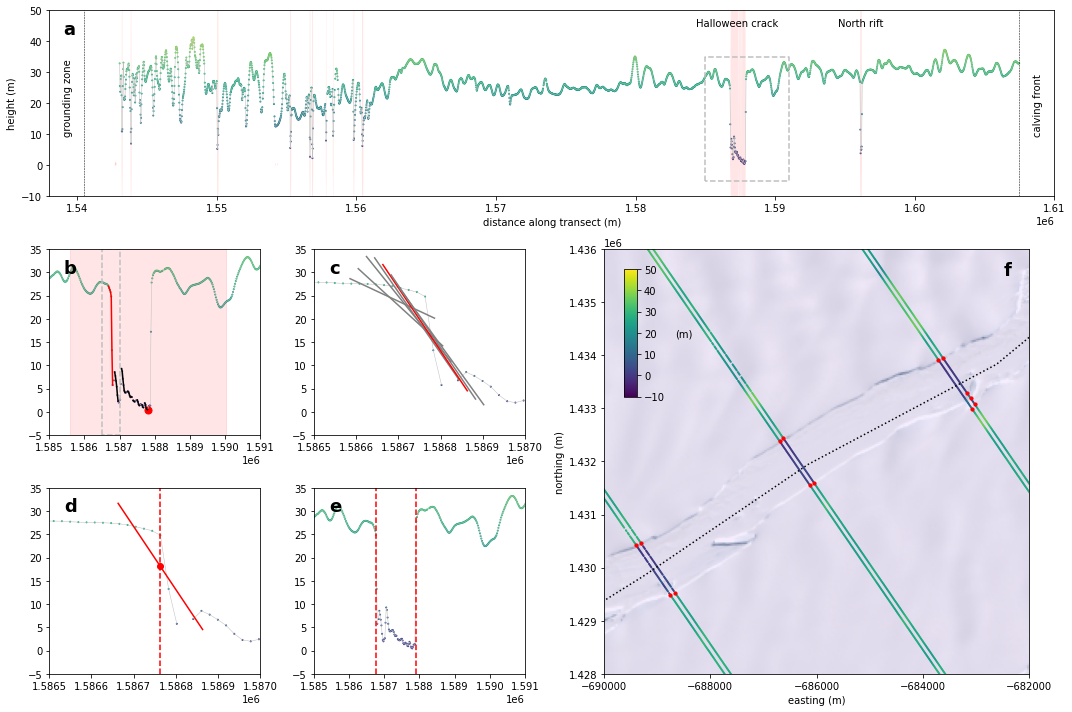

In [15]:
#1l

mdt = -1.1

fig = plt.figure(figsize=(15, 10))

gs = gridspec.GridSpec(3, 4)

plot_min = -10 #plot max and min for trace, colormap
plot_max = 50
plot_min_sub = -5 #plot max and min for subfigures
plot_max_sub = 35
dist_min = 1585000
dist_max = 1591000
dist_min_1_wall = 1586500
dist_max_1_wall = 1587000

gr = 0.75 #intensity of gray in plots

# Top
# ICESat-2 ATL06 transect across ice shelf with running mean, possible rift detections 
# highlight Halloween Crack (box), North Rift, Grounding line, calving front
ax0 = plt.subplot(gs[0,0:4])
pass_h = atl06_data_215_20210107["h"][12376]
pass_g = atl06_data_215_20210107["geoid"][12376]
pass_t = atl06_data_215_20210107["tides"][12376]
pass_h = pass_h - pass_g - pass_t - mdt
pass_x = atl06_data_215_20210107["x"][12376]
pass_y = atl06_data_215_20210107["y"][12376]
pass_d = np.sqrt((pass_x**2) + (pass_y**2))
ax0.plot(pass_d, pass_h, color=(gr,gr,gr), linewidth=0.5)
ax0.scatter(pass_d, pass_h, s=1, c=pass_h, vmin=plot_min, vmax=plot_max)

run_mean_dist = 10000
spacing = (max(pass_d) - min(pass_d)) / len(pass_d)
run_mean_nr = round(run_mean_dist / spacing)
h_run = pd.DataFrame(pass_h).rolling((2*run_mean_nr)+1, min_periods=1, center=True).mean()
h_run = h_run.values.flatten()

ax0.plot([np.min(pass_d),np.min(pass_d)], [plot_min,plot_max], '--', color=(0,0,0), linewidth=0.5)
ax0.annotate("calving front",(np.max(pass_d)+1000,np.mean([plot_min,plot_max])-10),rotation=90)
ax0.plot([np.max(pass_d),np.max(pass_d)], [plot_min,plot_max], '--', color=(0,0,0), linewidth=0.5)
ax0.annotate("grounding zone",(np.min(pass_d)-1500,np.mean([plot_min,plot_max])-10),rotation=90)
ax0.annotate("Halloween crack",(1587300,plot_max-5),ha='center')
ax0.annotate("North rift",(1596150,plot_max-5),ha='center')

ax0.annotate("a",(1538000+((0.02)*(1610000-1538000)),plot_max-(0.1*(plot_max-plot_min))),\
             size=18,weight='bold',ha='center',va='center')
ax0.set_xlabel('distance along transect (m)')
ax0.set_ylabel('height (m)')
ax0.set_xlim(1538000,1610000)
ax0.set_ylim(plot_min,plot_max)

pos_rift_bin = (pass_h<0.5*h_run)
pos_rift = pos_rift_bin.astype(int)*plot_max
ax0.fill(pass_d,pos_rift,'r',alpha=0.1)
pos_rift = pos_rift_bin.astype(int)*plot_min
ax0.fill(pass_d,pos_rift,'r',alpha=0.1)

ax0.plot([dist_min,dist_min,dist_max,dist_max,dist_min],\
         [plot_min_sub,plot_max_sub,plot_max_sub,plot_min_sub,plot_min_sub],\
         '--',color=(gr,gr,gr))

#--------------------------------------------------
# Top Left
# Expanded search area
ax1 = plt.subplot(gs[1,0])
ax1.plot(pass_d, pass_h, color=(gr,gr,gr), linewidth=0.5)
ax1.scatter(pass_d, pass_h, s=1, c=pass_h, vmin=plot_min, vmax=plot_max)
ax1.scatter(pass_d[2434], pass_h[2434], s=50, c='r') # lowest point
ax1.plot(pass_d[2377:2384], pass_h[2377:2384], c='r') # rift wall
ax1.plot(pass_d[2386:2392], pass_h[2386:2392], c='k')
ax1.plot(pass_d[2396:2403], pass_h[2396:2403], c='k')
ax1.plot(pass_d[2405:2410], pass_h[2405:2410], c='k')
ax1.plot(pass_d[2410:2416], pass_h[2410:2416], c='k')
ax1.plot(pass_d[2419:2423], pass_h[2419:2423], c='k')
ax1.plot(pass_d[2424:2429], pass_h[2424:2429], c='k')
ax1.plot(pass_d[2430:2435], pass_h[2430:2435], c='k')

search_start=pass_d[2320]
search_end=pass_d[2548]
ax1.add_patch(Rectangle((search_start,plot_min_sub),search_end-search_start,plot_max_sub-plot_min_sub,
                    edgecolor = 'red',
                    facecolor = 'red',
                    alpha = 0.1))

ax1.plot([dist_min_1_wall,dist_min_1_wall,dist_max_1_wall,dist_max_1_wall,dist_min_1_wall],\
         [plot_min_sub,plot_max_sub,plot_max_sub,plot_min_sub,plot_min_sub],\
         '--',color=(gr,gr,gr))

ax1.annotate("b",(dist_min+(0.1*(dist_max-dist_min)),plot_max_sub-(0.1*(plot_max_sub-plot_min_sub))),\
             size=18,weight='bold',ha='center',va='center')
ax1.set_xlim(dist_min,dist_max)
ax1.set_ylim(plot_min_sub,plot_max_sub)

#--------------------------------------------------
# Top Right
# Possible rift walls
ax2 = plt.subplot(gs[1,1])
ax2.plot(pass_d, pass_h, color=(gr,gr,gr), linewidth=0.5)
ax2.scatter(pass_d, pass_h, s=1, c=pass_h, vmin=plot_min, vmax=plot_max)

the_slopes  = [-0.0425, -0.0830, -0.1131, -0.1312, -0.1357, -0.1336, -0.1257]
the_inters  = [67494.8, 131866.9, 179621.5, 208265.4, 215341.8, 212129.3, 199565.5]
the_centers = [1586685.6, 1586705.0, 1586724.5, 1586743.9, 1586763.3, 1586782.8, 1586802.2]
the_hs      = [24.4, 22.5, 22.1, 20.0, 18.1, 16.1, 14.1]

for mi in range(0,7):
    the_center_h = (the_slopes[mi]*(the_centers[mi]))+(the_inters[mi])
    the_h = the_hs[mi]
    the_cor = the_center_h - the_h
    
    if mi == 4:
        ax2.plot([the_centers[mi]-100,the_centers[mi]+100],\
             [(the_slopes[mi]*(the_centers[mi]-100))+(the_inters[mi])-the_cor,(the_slopes[mi]*(the_centers[mi]+100))+(the_inters[mi])-the_cor],\
             '-',c='r')
    else:
        ax2.plot([the_centers[mi]-100,the_centers[mi]+100],\
             [(the_slopes[mi]*(the_centers[mi]-100))+(the_inters[mi])-the_cor,(the_slopes[mi]*(the_centers[mi]+100))+(the_inters[mi])-the_cor],\
             '-',c=(0.5,0.5,0.5))
        
ax2.annotate("c",(dist_min_1_wall+(0.1*(dist_max_1_wall-dist_min_1_wall)),plot_max_sub-(0.1*(plot_max_sub-plot_min_sub))),\
             size=18,weight='bold',ha='center',va='center')
ax2.set_xlim(dist_min_1_wall,dist_max_1_wall)
ax2.set_ylim(plot_min_sub,plot_max_sub)

#--------------------------------------------------
# Bottom Left
# Mini linear regression
ax3 = plt.subplot(gs[2,0])
ax3.plot(pass_d, pass_h, color=(gr,gr,gr), linewidth=0.5)
ax3.scatter(pass_d, pass_h, s=1, c=pass_h, vmin=plot_min, vmax=plot_max)
the_center_h = (the_slopes[4]*(the_centers[4]))+(the_inters[4])
the_h = the_hs[4]
the_cor = the_center_h - the_h
ax3.plot([the_centers[4]-100,the_centers[4]+100],\
        [(the_slopes[4]*(the_centers[4]-100))+(the_inters[4])-the_cor,(the_slopes[4]*(the_centers[4]+100))+(the_inters[4])-the_cor],\
         '-',c='r')
ax3.scatter(the_centers[4],the_h,c='r')
ax3.plot([1586763.3,1586763.3],[plot_min_sub,plot_max_sub],'--r')

ax3.annotate("d",(dist_min_1_wall+(0.1*(dist_max_1_wall-dist_min_1_wall)),plot_max_sub-(0.1*(plot_max_sub-plot_min_sub))),\
             size=18,weight='bold',ha='center',va='center')
ax3.set_xlim(dist_min_1_wall,dist_max_1_wall)
ax3.set_ylim(plot_min_sub,plot_max_sub)

#--------------------------------------------------
# Bottom Right
# Rift definition (3D?)
ax4 = plt.subplot(gs[2,1])
ax4.plot(pass_d, pass_h, color=(gr,gr,gr), linewidth=0.5)
ax4.scatter(pass_d, pass_h, s=1, c=pass_h, vmin=plot_min, vmax=plot_max)
ax4.plot([1586763.3,1586763.3],[plot_min_sub,plot_max_sub],'--r')
ax4.plot([1587891.3,1587891.3],[plot_min_sub,plot_max_sub],'--r')

ax4.annotate("e",(dist_min+(0.1*(dist_max-dist_min)),plot_max_sub-(0.1*(plot_max_sub-plot_min_sub))),\
             size=18,weight='bold',ha='center',va='center')
ax4.set_xlim(dist_min,dist_max)
ax4.set_ylim(plot_min_sub,plot_max_sub)

#--------------------------------------------------
# Right (map)
# Map 215 1l/r (+2,3l/r?) 2021-01-07 Landsat, ICESat-2, detections
ax5 = plt.subplot(gs[1:3,2:4])
show(satellite_to_plot.transpose(2,0,1), transform=band2.transform,ax=ax5)

# beam
for b in range(6):
    pass_x = atl06_data_215_20210107["x"].iloc[b]
    pass_y = atl06_data_215_20210107["y"].iloc[b]
    pass_h = atl06_data_215_20210107["h"].iloc[b]
    geoid  = atl06_data_215_20210107["geoid"].iloc[b]
    tides  = atl06_data_215_20210107["tides"].iloc[b]
    pass_h = pass_h - geoid - tides
    pl_is  = ax5.scatter(pass_x,pass_y,c=pass_h,vmin=plot_min,vmax=plot_max,s=1)

cbaxes = inset_axes(ax5, width="3%", height="30%",loc='upper left',borderpad=2)
cbar = plt.colorbar(pl_is,cax=cbaxes)

ax5.annotate("(m)",(-688500,1434400),ha='center',va='center')

x_starts = np.array(halloween_obs_unmerged_215_20210107['x-start'])
y_starts = np.array(halloween_obs_unmerged_215_20210107['y-start'])
x_ends = np.array(halloween_obs_unmerged_215_20210107['x-end'])
y_ends = np.array(halloween_obs_unmerged_215_20210107['y-end']) 

# rift
rift_path = pickle.load( open( '/data/fast1/arc/feature_outlines/halloween_path.pickle', "rb" ) )
riftx,rifty = np.array(rift_path.xy)
ax5.plot(riftx,rifty,'k:')

for r in range(len(halloween_obs_unmerged_215_20210107)):
    x_start = x_starts[r]
    y_start = y_starts[r]
    x_end = x_ends[r]
    y_end = y_ends[r]
    ax5.scatter(x_start,y_start,c='r',s=10)    
    ax5.scatter(x_end,y_end,c='r',s=10) 
    
mapxmin = -690000
mapxmax = -682000
mapymin = 1428000
mapymax = 1436000

ax5.annotate("f",(mapxmin+(0.95*(mapxmax-mapxmin)),mapymax-(0.05*(mapymax-mapymin))),\
             size=18,weight='bold',ha='center',va='center')
ax5.set_xlim(mapxmin,mapxmax)
ax5.set_ylim(mapymin,mapymax)
ax5.set_xlabel('easting (m)')
ax5.set_ylabel('northing (m)')
ax5.locator_params(axis='x', nbins=5)

plt.tight_layout()

output = figure_folder+'/fig03_detection.png'
plt.savefig(output,dpi=100, bbox_inches='tight')

plt.show()


# Supplementary figures

### Reference Ground Tracks

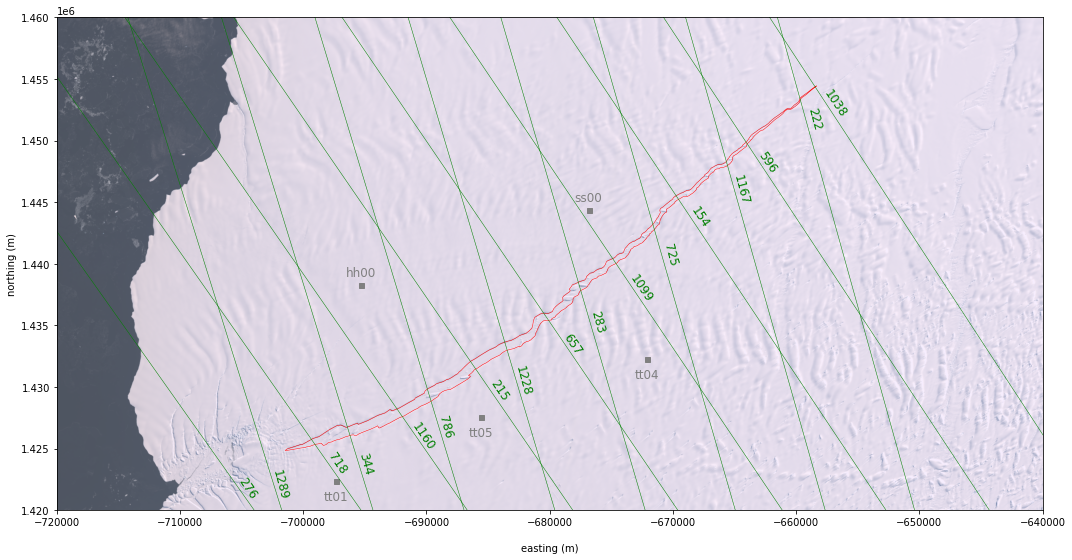

In [16]:
gr = 0.25 # gray
ftsz = 8  # fontsize

fig = plt.figure(figsize=(15, 15))

ax6=plt.subplot(1,1,1)

show(norm1.transpose(2,0,1), transform=img1_2.transform, ax=ax6)

# plot the GPS locations
ax6.plot(hh00_x[1],hh00_y[1],'s',color='gray',markersize=5)
ax6.plot(tt05_x[1],tt05_y[1],'s',color='gray',markersize=5)
ax6.plot(ss00_x[0],ss00_y[0],'s',color='gray',markersize=5)
ax6.plot(tt04_x[1],tt04_y[1],'s',color='gray',markersize=5)
ax6.plot(tt01_x[1],tt01_y[1],'s',color='gray',markersize=5)
ax6.text(hh00_x[1], hh00_y[1]+1000, 'hh00', fontsize=12, color='gray',ha='center',va='center')
ax6.text(tt05_x[1], tt05_y[1]-1250, 'tt05', fontsize=12, color='gray',ha='center',va='center')
ax6.text(ss00_x[1], ss00_y[1]+1000, 'ss00', fontsize=12, color='gray',ha='center',va='center')
ax6.text(tt04_x[1], tt04_y[1]-1250, 'tt04', fontsize=12, color='gray',ha='center',va='center')
ax6.text(tt01_x[1], tt01_y[1]-1250, 'tt01', fontsize=12, color='gray',ha='center',va='center')


shapefileHC.plot(color='r',linewidth=0.5,ax=ax6)

# HC rgts
#276,1289,718,344,1160,786,215,1228,657,283,1099,725,154,1167,596,222,1038
hcrgtnrs=[44,214,117,56,191,129,34,203,107,45,181,118,24,192,97,35,171]
for h in hcrgtnrs:    
    easting = shapefile7_ar["easting"][h]
    northing = shapefile7_ar["northing"][h]
    ax6.plot(easting,northing,'g',linewidth=0.5)

subxmin = -720000
subxmax = -640000
subymin = 1420000
subymax = 1460000
ax6.set_xlim(subxmin,subxmax)
ax6.set_ylim(subymin,subymax)

#annotate
ax6.text(-658000, 1452000, '1038', rotation=-56, fontsize=12, color='g')
ax6.text(-659300, 1451000, '222', rotation=-75, fontsize=12, color='g')
ax6.text(-663300, 1447500, '596', rotation=-56, fontsize=12, color='g')
ax6.text(-665300, 1445000, '1167', rotation=-75, fontsize=12, color='g')
ax6.text(-668800, 1443000, '154', rotation=-56, fontsize=12, color='g')
ax6.text(-671000, 1440000, '725', rotation=-75, fontsize=12, color='g')
ax6.text(-673700, 1437000, '1099', rotation=-56, fontsize=12, color='g')
ax6.text(-676900, 1434500, '283', rotation=-75, fontsize=12, color='g')
ax6.text(-679100, 1432700, '657', rotation=-56, fontsize=12, color='g')
ax6.text(-683000, 1429500, '1228', rotation=-75, fontsize=12, color='g')
ax6.text(-685000, 1429000, '215', rotation=-56, fontsize=12, color='g')
ax6.text(-689200, 1426000, '786', rotation=-75, fontsize=12, color='g')
ax6.text(-691400, 1425000, '1160', rotation=-56, fontsize=12, color='g')
ax6.text(-695700, 1423000, '344', rotation=-75, fontsize=12, color='g')
ax6.text(-698200, 1423000, '718', rotation=-56, fontsize=12, color='g')
ax6.text(-702700, 1421000, '1289', rotation=-75, fontsize=12, color='g')
ax6.text(-705500, 1421000, '276', rotation=-56, fontsize=12, color='g')

ax6.set_xlabel("\neasting (m)", fontsize=ftsz+2)
ax6.set_ylabel("northing (m)", fontsize=ftsz+2)


plt.tight_layout()

output = figure_folder+'/figS02_rgts_new_gps5.png'
plt.savefig(output, dpi=100, bbox_inches='tight')


plt.show()

### GNSS

/tmp/ipykernel_3778450/3346947518.py:253: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


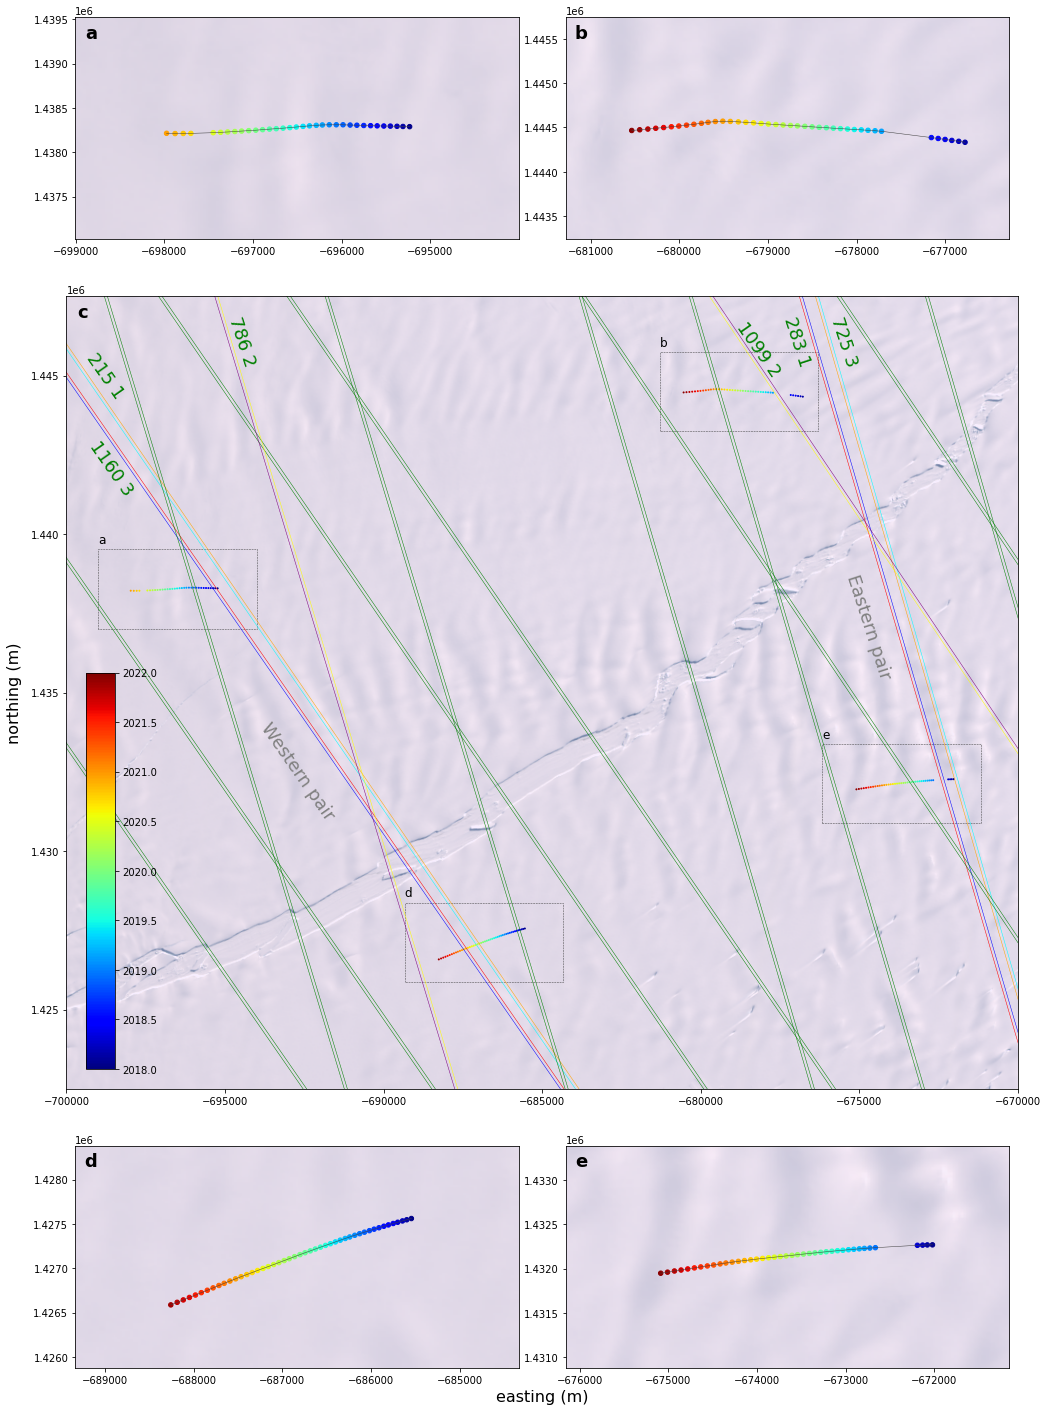

In [17]:
pad=2500
padx=pad
pady=0.5*pad
gr = 0.25 # gray
ftsz = 8  # fontsize

yr_min = 2018
yr_max = 2022

fig = plt.figure(figsize=(15,20))

gs = gridspec.GridSpec(16, 12)

#hh00
ax1 = plt.subplot(gs[0:3,0:6])
show(norm1.transpose(2,0,1), transform=img1_2.transform, ax=ax1)
ax1.plot(hh00_x,hh00_y,color=(gr,gr,gr),linewidth=0.5)
ax1.scatter(gps_x,gps_y,s=20,c=gps_t,cmap='jet',vmin=yr_min,vmax=yr_max)
ax1.set_xlim(np.mean(hh00_x)-padx,np.mean(hh00_x)+padx)
ax1.set_ylim(np.mean(hh00_y)-pady,np.mean(hh00_y)+pady)

#ss00
ax2 = plt.subplot(gs[0:3,6:12])
show(norm1.transpose(2,0,1), transform=img1_2.transform, ax=ax2)
ax2.plot(ss00_x,ss00_y,color=(gr,gr,gr),linewidth=0.5)
ax2.scatter(gps_x,gps_y,s=20,c=gps_t,cmap='jet',vmin=yr_min,vmax=yr_max)
ax2.set_xlim(np.mean(ss00_x)-padx,np.mean(ss00_x)+padx)
ax2.set_ylim(np.mean(ss00_y)-pady,np.mean(ss00_y)+pady)


ax3 = plt.subplot(gs[3:13,0:12])
show(norm1.transpose(2,0,1), transform=img1_2.transform, ax=ax3)
pl_gps = ax3.scatter(gps_x,gps_y,s=1,c=gps_t,cmap='jet',vmin=yr_min,vmax=yr_max)
cbaxes = inset_axes(ax3, width="3%", height="50%",loc='lower left',borderpad=2)
cbar = plt.colorbar(pl_gps,cax=cbaxes)
ax3.set_xlim(-700000,-670000)
ax3.set_ylim(1422500,1447500)
ax3.plot([np.mean(hh00_x)-padx,np.mean(hh00_x)-padx,np.mean(hh00_x)+padx,np.mean(hh00_x)+padx,np.mean(hh00_x)-padx],\
           [np.mean(hh00_y)-pady,np.mean(hh00_y)+pady,np.mean(hh00_y)+pady,np.mean(hh00_y)-pady,np.mean(hh00_y)-pady],\
           '--',color=(gr,gr,gr),linewidth=0.5)
ax3.plot([np.mean(tt05_x)-padx,np.mean(tt05_x)-padx,np.mean(tt05_x)+padx,np.mean(tt05_x)+padx,np.mean(tt05_x)-padx],\
           [np.mean(tt05_y)-pady,np.mean(tt05_y)+pady,np.mean(tt05_y)+pady,np.mean(tt05_y)-pady,np.mean(tt05_y)-pady],\
           '--',color=(gr,gr,gr),linewidth=0.5)
ax3.plot([np.mean(ss00_x)-padx,np.mean(ss00_x)-padx,np.mean(ss00_x)+padx,np.mean(ss00_x)+padx,np.mean(ss00_x)-padx],\
           [np.mean(ss00_y)-pady,np.mean(ss00_y)+pady,np.mean(ss00_y)+pady,np.mean(ss00_y)-pady,np.mean(ss00_y)-pady],\
           '--',color=(gr,gr,gr),linewidth=0.5)
ax3.plot([np.mean(tt04_x)-padx,np.mean(tt04_x)-padx,np.mean(tt04_x)+padx,np.mean(tt04_x)+padx,np.mean(tt04_x)-padx],\
           [np.mean(tt04_y)-pady,np.mean(tt04_y)+pady,np.mean(tt04_y)+pady,np.mean(tt04_y)-pady,np.mean(tt04_y)-pady],\
           '--',color=(gr,gr,gr),linewidth=0.5)

#tt05
ax4 = plt.subplot(gs[13:16,0:6])
show(norm1.transpose(2,0,1), transform=img1_2.transform, ax=ax4)
ax4.plot(tt05_x,tt05_y,color=(gr,gr,gr),linewidth=0.5)
ax4.scatter(gps_x,gps_y,s=20,c=gps_t,cmap='jet',vmin=yr_min,vmax=yr_max)
ax4.set_xlim(np.mean(tt05_x)-padx,np.mean(tt05_x)+padx)
ax4.set_ylim(np.mean(tt05_y)-pady,np.mean(tt05_y)+pady)

#tt04
ax5 = plt.subplot(gs[13:16,6:12])
show(norm1.transpose(2,0,1), transform=img1_2.transform, ax=ax5)
ax5.plot(tt04_x,tt04_y,color=(gr,gr,gr),linewidth=0.5)
ax5.scatter(gps_x,gps_y,s=20,c=gps_t,cmap='jet',vmin=yr_min,vmax=yr_max)
ax5.set_xlim(np.mean(tt04_x)-padx,np.mean(tt04_x)+padx)
ax5.set_ylim(np.mean(tt04_y)-pady,np.mean(tt04_y)+pady)


#215
#1L
easting = shapefile1L_ar["easting"][34]
northing = shapefile1L_ar["northing"][34]
ax3.plot(easting,northing,'orange',linewidth=0.5)
#1R
easting = shapefile1R_ar["easting"][34]
northing = shapefile1R_ar["northing"][34]
ax3.plot(easting,northing,'cyan',linewidth=0.5)
#2L
easting = shapefile2L_ar["easting"][34]
northing = shapefile2L_ar["northing"][34]
ax3.plot(easting,northing,'g',linewidth=0.5)
#2R
easting = shapefile2R_ar["easting"][34]
northing = shapefile2R_ar["northing"][34]
ax3.plot(easting,northing,'g',linewidth=0.5)
#3L
easting = shapefile3L_ar["easting"][32]
northing = shapefile3L_ar["northing"][32]
ax3.plot(easting,northing,'g',linewidth=0.5)
#3R
easting = shapefile3R_ar["easting"][32]
northing = shapefile3R_ar["northing"][32]
ax3.plot(easting,northing,'g',linewidth=0.5)

#1160
#1L
easting = shapefile1L_ar["easting"][190]
northing = shapefile1L_ar["northing"][190]
ax3.plot(easting,northing,'g',linewidth=0.5)
#1R
easting = shapefile1R_ar["easting"][190]
northing = shapefile1R_ar["northing"][190]
ax3.plot(easting,northing,'g',linewidth=0.5)
#2L
easting = shapefile2L_ar["easting"][191]
northing = shapefile2L_ar["northing"][191]
ax3.plot(easting,northing,'g',linewidth=0.5)
#2R
easting = shapefile2R_ar["easting"][192]
northing = shapefile2R_ar["northing"][192]
ax3.plot(easting,northing,'g',linewidth=0.5)
#3L
easting = shapefile3L_ar["easting"][176]
northing = shapefile3L_ar["northing"][176]
ax3.plot(easting,northing,'r',linewidth=0.5)
#3R
easting = shapefile3R_ar["easting"][176]
northing = shapefile3R_ar["northing"][176]
ax3.plot(easting,northing,'b',linewidth=0.5)

#786
#1L
easting = shapefile1L_ar["easting"][129]
northing = shapefile1L_ar["northing"][129]
ax3.plot(easting,northing,'g',linewidth=0.5)
#1R
easting = shapefile1R_ar["easting"][129]
northing = shapefile1R_ar["northing"][129]
ax3.plot(easting,northing,'g',linewidth=0.5)
#2L
easting = shapefile2L_ar["easting"][129]
northing = shapefile2L_ar["northing"][129]
ax3.plot(easting,northing,'purple',linewidth=0.5)
#2R
easting = shapefile2R_ar["easting"][130]
northing = shapefile2R_ar["northing"][130]
ax3.plot(easting,northing,'yellow',linewidth=0.5)
#3L
easting = shapefile3L_ar["easting"][119]
northing = shapefile3L_ar["northing"][119]
ax3.plot(easting,northing,'g',linewidth=0.5)
#3R
easting = shapefile3R_ar["easting"][119]
northing = shapefile3R_ar["northing"][119]
ax3.plot(easting,northing,'g',linewidth=0.5)

#283
#1L
easting = shapefile1L_ar["easting"][45]
northing = shapefile1L_ar["northing"][45]
ax3.plot(easting,northing,'red',linewidth=0.5)
#1R
easting = shapefile1R_ar["easting"][45]
northing = shapefile1R_ar["northing"][45]
ax3.plot(easting,northing,'blue',linewidth=0.5)
#2L
easting = shapefile2L_ar["easting"][45]
northing = shapefile2L_ar["northing"][45]
ax3.plot(easting,northing,'g',linewidth=0.5)
#2R
easting = shapefile2R_ar["easting"][45]
northing = shapefile2R_ar["northing"][45]
ax3.plot(easting,northing,'g',linewidth=0.5)
#3L
easting = shapefile3L_ar["easting"][42]
northing = shapefile3L_ar["northing"][42]
ax3.plot(easting,northing,'g',linewidth=0.5)
#3R
easting = shapefile3R_ar["easting"][42]
northing = shapefile3R_ar["northing"][42]
ax3.plot(easting,northing,'g',linewidth=0.5)

#725
#1L
easting = shapefile1L_ar["easting"][118]
northing = shapefile1L_ar["northing"][118]
ax3.plot(easting,northing,'g',linewidth=0.5)
#1R
easting = shapefile1R_ar["easting"][118]
northing = shapefile1R_ar["northing"][118]
ax3.plot(easting,northing,'g',linewidth=0.5)
#2L
easting = shapefile2L_ar["easting"][118]
northing = shapefile2L_ar["northing"][118]
ax3.plot(easting,northing,'g',linewidth=0.5)
#2R
easting = shapefile2R_ar["easting"][119]
northing = shapefile2R_ar["northing"][119]
ax3.plot(easting,northing,'g',linewidth=0.5)
#3L
easting = shapefile3L_ar["easting"][109]
northing = shapefile3L_ar["northing"][109]
ax3.plot(easting,northing,'orange',linewidth=0.5)
#3R
easting = shapefile3R_ar["easting"][109]
northing = shapefile3R_ar["northing"][109]
ax3.plot(easting,northing,'cyan',linewidth=0.5)

#1099
#1L
easting = shapefile1L_ar["easting"][180]
northing = shapefile1L_ar["northing"][180]
ax3.plot(easting,northing,'g',linewidth=0.5)
#1R
easting = shapefile1R_ar["easting"][180]
northing = shapefile1R_ar["northing"][180]
ax3.plot(easting,northing,'g',linewidth=0.5)
#2L
easting = shapefile2L_ar["easting"][181]
northing = shapefile2L_ar["northing"][181]
ax3.plot(easting,northing,'purple',linewidth=0.5)
#2R
easting = shapefile2R_ar["easting"][182]
northing = shapefile2R_ar["northing"][182]
ax3.plot(easting,northing,'yellow',linewidth=0.5)
#3L
easting = shapefile3L_ar["easting"][167]
northing = shapefile3L_ar["northing"][167]
ax3.plot(easting,northing,'g',linewidth=0.5)
#3R
easting = shapefile3R_ar["easting"][167]
northing = shapefile3R_ar["northing"][167]
ax3.plot(easting,northing,'g',linewidth=0.5)

ax3.text(-699500, 1444000, '215 1  ', rotation=-55, fontsize=18, color='g')
ax3.text(-699400, 1441250, '1160 3', rotation=-55, fontsize=18, color='g')
ax3.text(-677500, 1445000, '283 1  ', rotation=-72, fontsize=18, color='g')
ax3.text(-676000, 1445000, '725 3  ', rotation=-72, fontsize=18, color='g')
ax3.text(-695000, 1445000, '786 2  ', rotation=-72, fontsize=18, color='g')
ax3.text(-679000, 1445000, '1099 2', rotation=-55, fontsize=18, color='g')

ax3.text(-694000, 1431000, 'Western pair', rotation=-55, fontsize=18,color='gray')
ax3.text(-675500, 1435500, 'Eastern pair', rotation=-72, fontsize=18,color='gray')

#a-e
ax1.annotate("a",(np.mean(hh00_x)-padx+175,np.mean(hh00_y)+pady-175),size=18,weight='bold',ha='center',va='center')
ax2.annotate("b",(np.mean(ss00_x)-padx+175,np.mean(ss00_y)+pady-175),size=18,weight='bold',ha='center',va='center')
ax3.annotate("c",(-700000+500,1447500-500),size=18,weight='bold',ha='center',va='center')
ax4.annotate("d",(np.mean(tt05_x)-padx+175,np.mean(tt05_y)+pady-175),size=18,weight='bold',ha='center',va='center')
ax5.annotate("e",(np.mean(tt04_x)-padx+175,np.mean(tt04_y)+pady-175),size=18,weight='bold',ha='center',va='center')

ax3.annotate("a",(np.mean(hh00_x)-padx,np.mean(hh00_y)+pady+100),size=12,ha='left',va='bottom')
ax3.annotate("b",(np.mean(ss00_x)-padx,np.mean(ss00_y)+pady+100),size=12,ha='left',va='bottom')
ax3.annotate("d",(np.mean(tt05_x)-padx,np.mean(tt05_y)+pady+100),size=12,ha='left',va='bottom')
ax3.annotate("e",(np.mean(tt04_x)-padx,np.mean(tt04_y)+pady+100),size=12,ha='left',va='bottom')

# hidden big axes for common axis labels 
ax6 = fig.add_subplot(111, frameon=False)
ax6.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax6.grid(False)
ax6.set_xlabel("easting (m)", fontsize=16)
ax6.set_ylabel("northing (m)\n", fontsize=16)

plt.tight_layout()

output = figure_folder+'/figS03_gnss.png'
plt.savefig(output, dpi=100, bbox_inches='tight')

plt.show()


### Opening width and wall-to-wall width

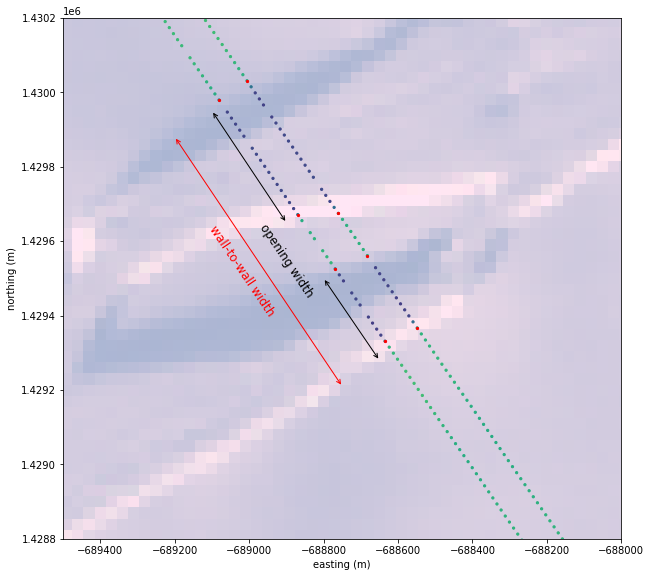

In [18]:
plot_min = -10
plot_max = 50

mdt = -1.1
gr = 0.75

fig=plt.figure(figsize=(10,10))

# 215 1-5

#------------------------------
#2019-04-12
#row 1 L


atl06_plot = atl06_data[(atl06_data["rgt"]==215)&\
                (atl06_data["beam"]=='1l')&\
                (atl06_data["time"]=="2019-04-12 09:11:15.279099+00:00")]

passl_h = atl06_plot["h"].iloc[0]
passl_g = atl06_plot["geoid"].iloc[0]
passl_t = atl06_plot["tides"].iloc[0]
passl_h = passl_h - passl_g - passl_t - mdt
passl_x = atl06_plot["x"].iloc[0]
passl_y = atl06_plot["y"].iloc[0]
passl_d = np.sqrt((passl_x**2) + (passl_y**2))

hcl_plot = halloween_obs_unmerged[(halloween_obs_unmerged["rgt"]==215)&\
                (halloween_obs_unmerged["beam"]=='1l')&\
                (halloween_obs_unmerged["time"]=="2019-04-12 09:11:15.279099+00:00")]

dl_starts = hcl_plot["d-start"]
dl_ends = hcl_plot["d-end"]
dl_confs = hcl_plot["confidence"]
xl_starts = hcl_plot["x-start"]
xl_ends = hcl_plot["x-end"]
yl_starts = hcl_plot["y-start"]
yl_ends = hcl_plot["y-end"]

atl06_plot = atl06_data[(atl06_data["rgt"]==215)&\
                (atl06_data["beam"]=='1r')&\
                (atl06_data["time"]=="2019-04-12 09:11:15.279099+00:00")]

passr_h = atl06_plot["h"].iloc[0]
passr_g = atl06_plot["geoid"].iloc[0]
passr_t = atl06_plot["tides"].iloc[0]
passr_h = passr_h - passr_g - passr_t - mdt
passr_x = atl06_plot["x"].iloc[0]
passr_y = atl06_plot["y"].iloc[0]
passr_d = np.sqrt((passr_x**2) + (passr_y**2))

hcr_plot = halloween_obs_unmerged[(halloween_obs_unmerged["rgt"]==215)&\
                (halloween_obs_unmerged["beam"]=='1r')&\
                (halloween_obs_unmerged["time"]=="2019-04-12 09:11:15.279099+00:00")]

dr_starts = hcr_plot["d-start"]
dr_ends = hcr_plot["d-end"]
dr_confs = hcr_plot["confidence"]
xr_starts = hcr_plot["x-start"]
xr_ends = hcr_plot["x-end"]
yr_starts = hcr_plot["y-start"]
yr_ends = hcr_plot["y-end"]
     
ax12=fig.add_subplot(1,1,1)
sat = 'LC08_L1GT_182114_20190323_20200829_02_T2'
landsat_B4_name = satellite_path+'landsat/'+sat+'/'+sat+'_B4.TIF'
landsat_B3_name = satellite_path+'landsat/'+sat+'/'+sat+'_B3.TIF'
landsat_B2_name = satellite_path+'landsat/'+sat+'/'+sat+'_B2.TIF'
band4 = rasterio.open(landsat_B4_name)
band3 = rasterio.open(landsat_B3_name)
band2 = rasterio.open(landsat_B2_name)

# Prevent dull images
b4 = band4.read(1)
b4[b4>np.percentile(b4,99)] = np.percentile(b4,99)
b3 = band3.read(1)
b3[b3>np.percentile(b3,99)] = np.percentile(b3,99)
b2 = band2.read(1)
b2[b2>np.percentile(b2,99)] = np.percentile(b2,99)

image = np.array([b4,b3,b2]).transpose(1,2,0)
L8_to_plot = (image * (255 / np.max(image))).astype(np.uint8)

show(L8_to_plot.transpose(2,0,1), transform=band4.transform,ax=ax12)
ax12.scatter(passl_x, passl_y, c=passl_h, vmin=plot_min, vmax=plot_max, s=5)
ax12.scatter(passr_x, passr_y, c=passr_h, vmin=plot_min, vmax=plot_max, s=5)
 
for r in range(0,len(hcl_plot)):
    x_start = xl_starts.iloc[r]
    x_end = xl_ends.iloc[r]
    y_start = yl_starts.iloc[r]
    y_end = yl_ends.iloc[r]
    d_conf = dl_confs.iloc[r]
    if d_conf == "high":
        fcol = "red"
    else:
        fcol = "orange"
    ax12.scatter(x_start,y_start,c=fcol,s=5)    
    ax12.scatter(x_end,y_end,c=fcol,s=5)
    
for r in range(0,len(hcr_plot)):
    x_start = xr_starts.iloc[r]
    x_end = xr_ends.iloc[r]
    y_start = yr_starts.iloc[r]
    y_end = yr_ends.iloc[r]
    d_conf = dr_confs.iloc[r]
    if d_conf == "high":
        fcol = "red"
    else:
        fcol = "orange"
    ax12.scatter(x_start,y_start,c=fcol,s=5)    
    ax12.scatter(x_end,y_end,c=fcol,s=5)

ax12.set_xlim(-689500,-688000)
ax12.set_ylim(1428800,1430200)

ax12.annotate('', xy=(-688650,1429280), xytext=(-688800,1429500), arrowprops=dict(arrowstyle='<->'))
ax12.annotate('', xy=(-688900,1429650), xytext=(-689100,1429950), arrowprops=dict(arrowstyle='<->'))

ax12.annotate('', xy=(-688750,1429210), xytext=(-689200,1429880), arrowprops=dict(arrowstyle='<->',color='red'))

ax12.annotate("opening width",(-688900,1429450),fontsize=12,ha="center",rotation = -56)
ax12.annotate("wall-to-wall width",(-689020,1429400),fontsize=12,ha="center",rotation = -56,color='red')

ax12.set_xlabel('easting (m)')
ax12.set_ylabel('northing (m)')

output = figure_folder+'/figS04_split_width.png'
plt.savefig(output, dpi=200, bbox_inches='tight')

plt.show()